# This notebook is an example notebook to inference autoencdoer.

In [1]:
import argparse, os, sys, glob
sys.path.append(os.getcwd()+"/ldm")
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
from ldm.ldm.util import instantiate_from_config
from ldm.ldm.models.diffusion.ddim import DDIMSampler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as T
transform = T.ToPILImage()

/home/nicky/anaconda3/envs/ldm-inpaint/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
yaml_path = "/home/nicky/latent-diffusion-inpainting/ldm/models/first_stage_models/vq-f4-noattn/config.yaml"
data_path = "/home/nicky/polyp_dataset/done/images/test"
ckpt_path = "/home/nicky/latent-diffusion-inpainting/ldm/auto.ckpt"

In [3]:
class Image_dataset(Dataset):
    def __init__(self, size, data_root, config=None):
        self.size = size
        self.data_root=data_root
        self.image_list = []
        
        for image in os.listdir(data_root):
            self.image_list.append(data_root+"/"+image)
                        

    def __len__(self):
        return len(self.image_list)


    def __getitem__(self, i):

        image = np.array(Image.open(self.image_list[i]).convert("RGB").resize((self.size,self.size)))
        image = image.astype(np.float32) / 255.0#
        image = image[None].transpose(0,3,1,2)
        #image = image[None].transpose(0,3,1,2)
        image = torch.from_numpy(image)
        
        

        batch = {"image": np.squeeze(image,0)}
        for k in batch:
            batch[k] = batch[k] * 2.0 - 1.0

        return batch

In [4]:
##load the config
config_auto = OmegaConf.load(yaml_path)

##generate the model from config
auto = instantiate_from_config(config_auto.model)

##load the state dict
auto.load_state_dict(torch.load(ckpt_path)['state_dict'],strict=False)

making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels


/home/nicky/anaconda3/envs/ldm-inpaint/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nicky/anaconda3/envs/ldm-inpaint/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


<All keys matched successfully>

In [5]:
dataSet=Image_dataset(512,data_path)
loader = DataLoader(
    dataSet,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

In [6]:
batch=next(iter(loader))

In [7]:
##using cpu, not gpu
output=auto(batch['image'])

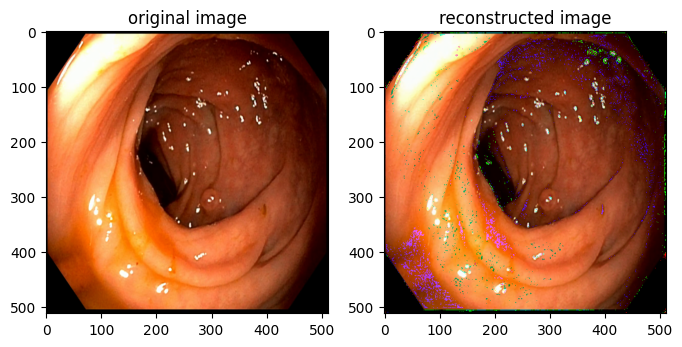

In [8]:
##Original Image
original_image=transform(batch['image'][0]*0.5+0.5)

##Output Image
output_image=transform(output[0][0]*0.5+0.5)


fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

# Display each image on a separate subplot
axes[0].imshow(original_image)
axes[0].set_title('original image')

axes[1].imshow(output_image)
axes[1].set_title('reconstructed image')


plt.show()